## Header

### Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import numpy as np
import cv2
import h5py
import tifffile
import tqdm
import sys
import time
import IPython
import re
import torch


### Funcs

In [2]:
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def loadImage(imageName, expectedShape=None) :
    if not imageName:
        return None
    #imdata = imread(imageName).astype(np.float32)
    imdata = tifffile.imread(imageName).astype(np.float32)
    if len(imdata.shape) == 3 :
        imdata = np.mean(imdata[:,:,0:3], 2)
    if not expectedShape is None  and  imdata.shape != expectedShape :
        raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                        f"do not match expected shape {expectedShape}.")
    return imdata


def loadData(dataName) :
    results = []
    with open(dataName) as file:
        for line in file:
            numbers = re.findall(r'\d+', line)
            while len(results) < len(numbers) :
                results.append([])
                if len(results[-1]) != len(results[0]) :
                    results[-1] = [None] * len(results[0])
            for resI in range(len(results)) :
                results[resI].append( float(numbers[resI]) if resI < len(numbers) else None)
    return results



def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple and type(dataY) is not list:
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)
    else :
        plt.show()


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()



### Read input

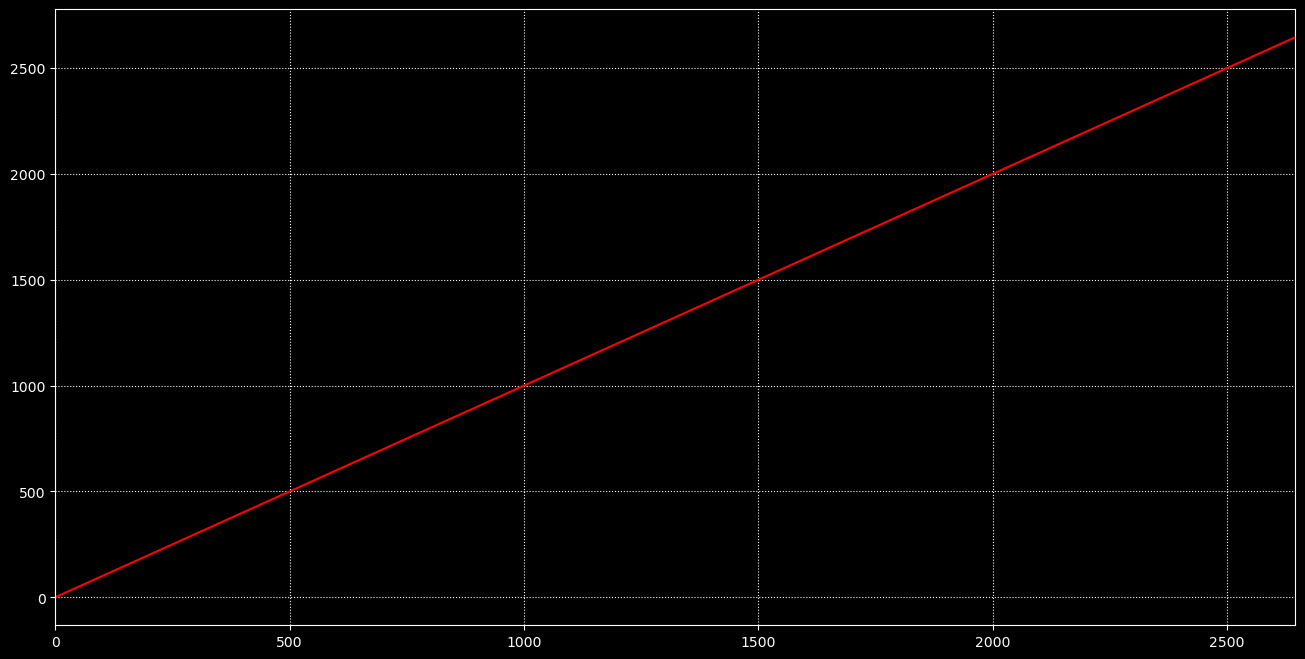

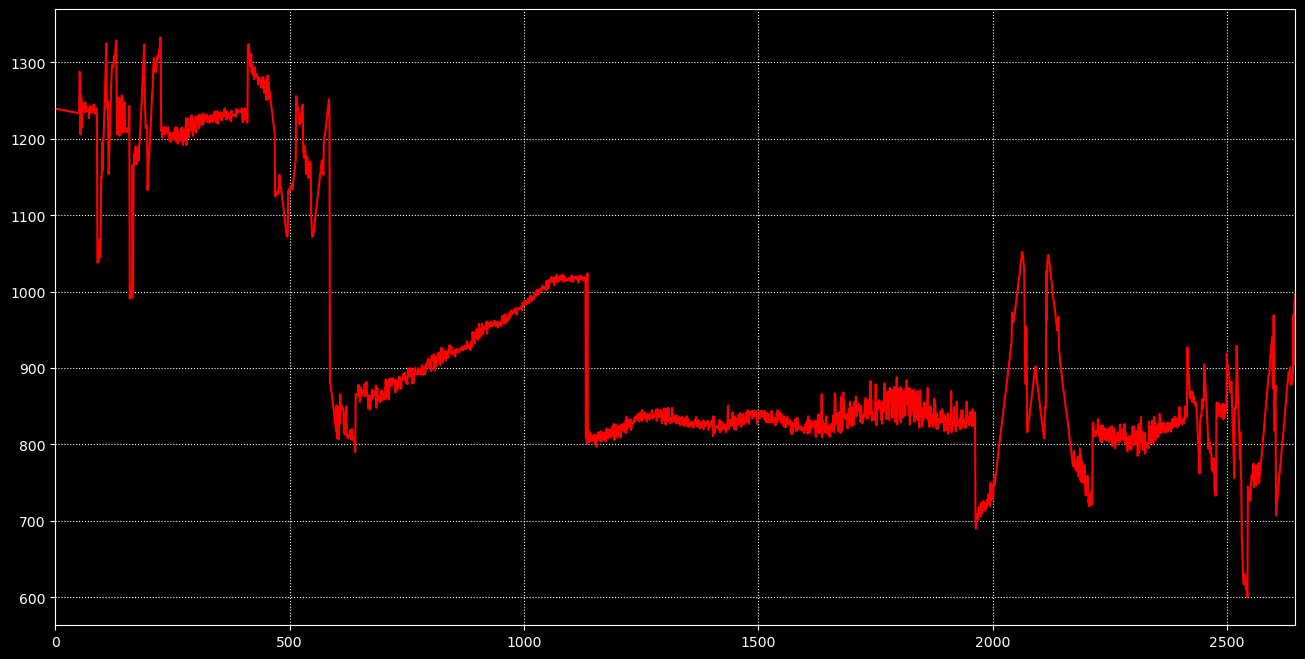

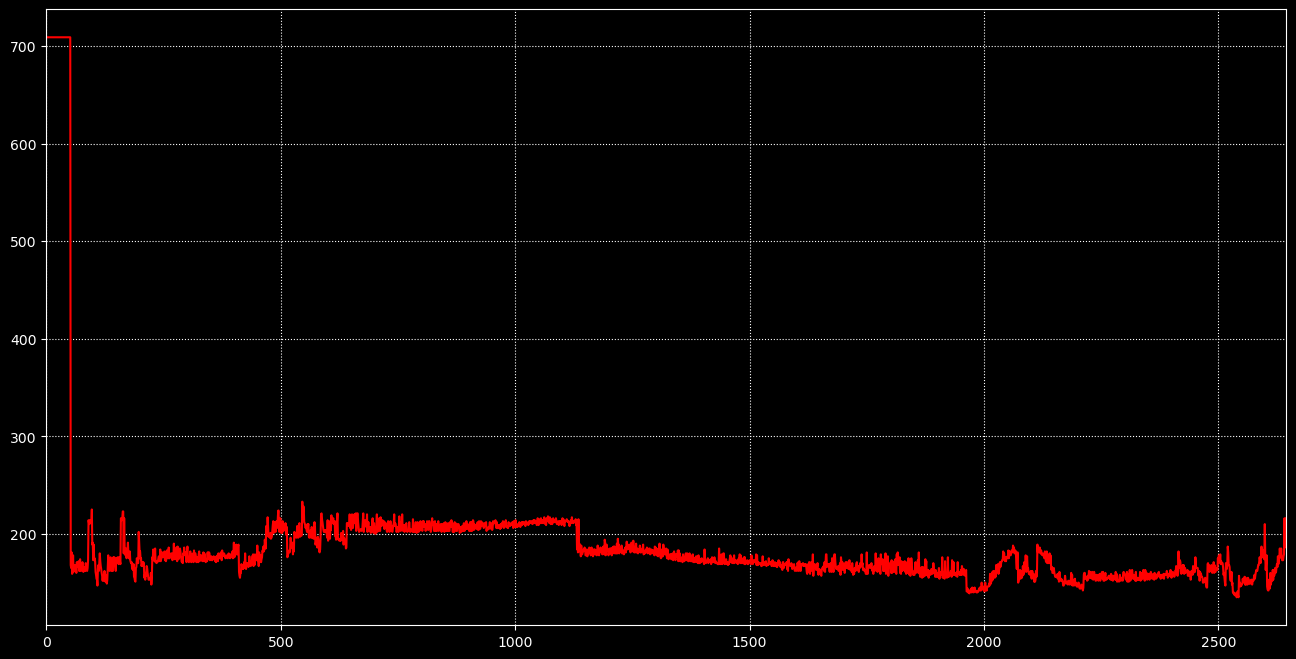

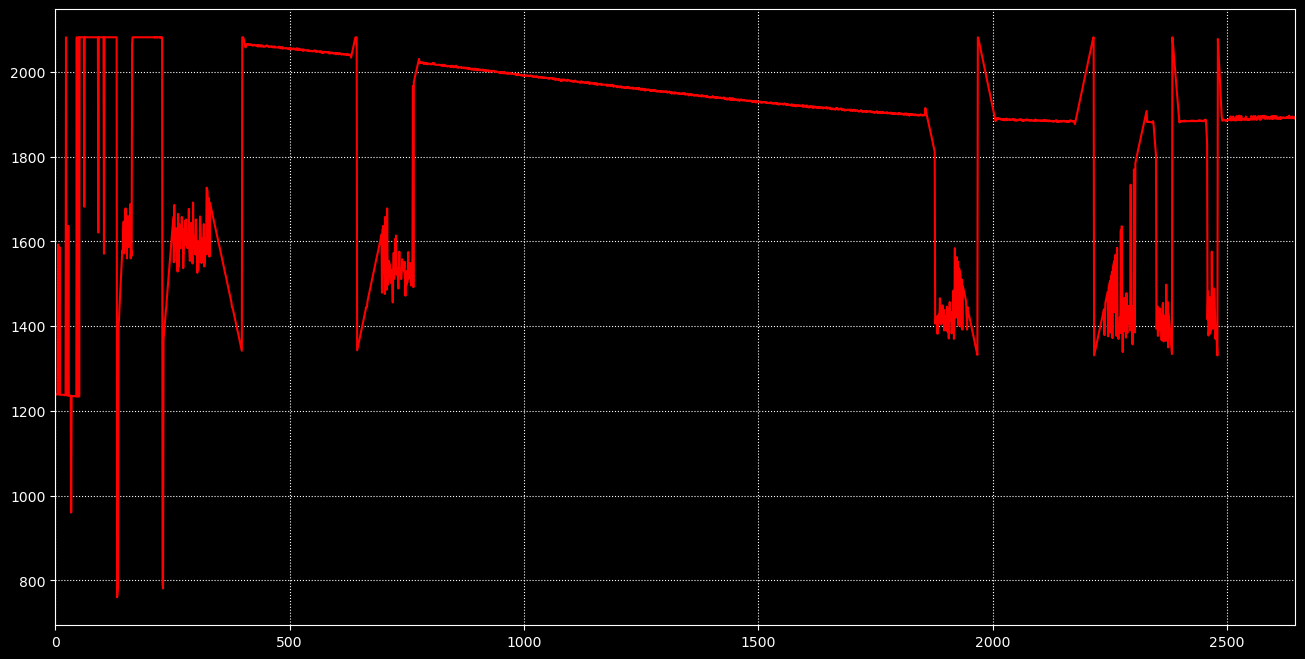

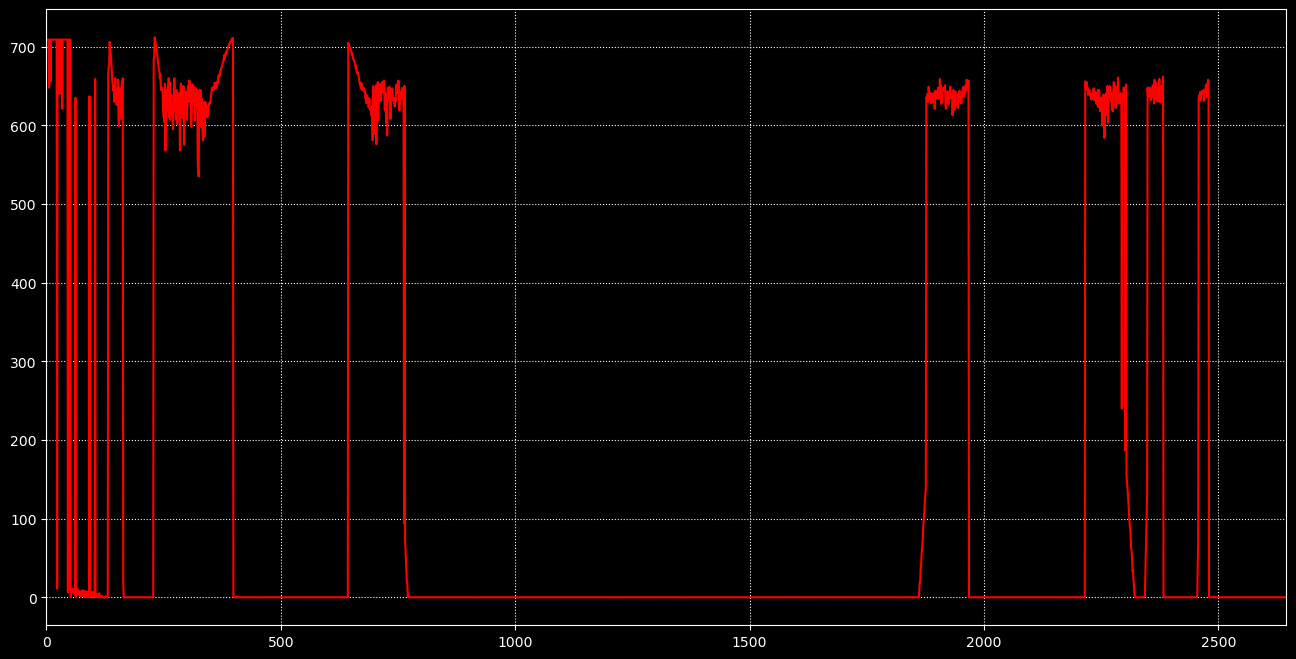

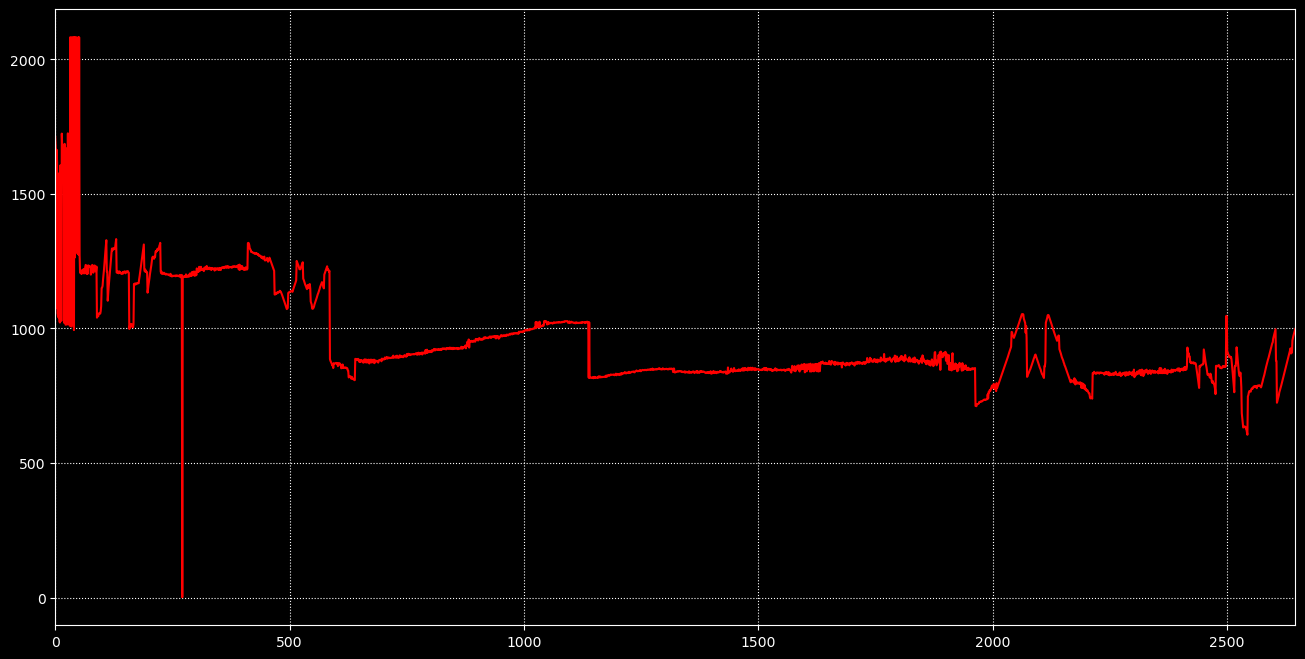

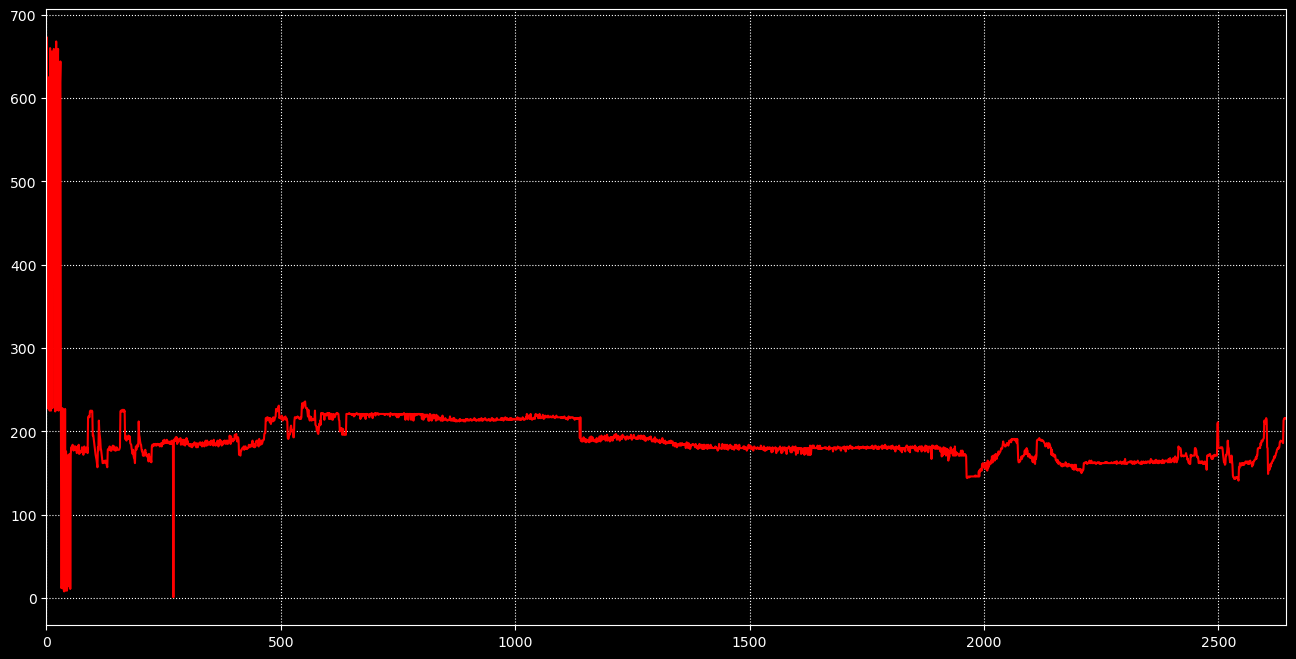

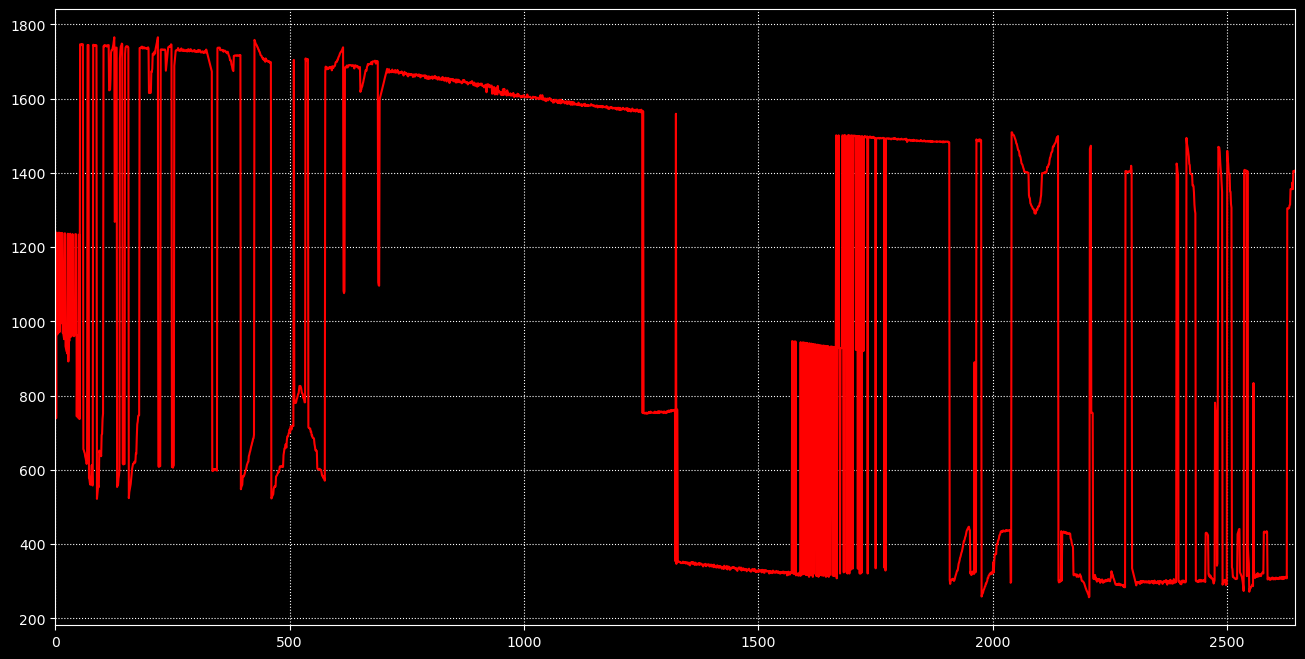

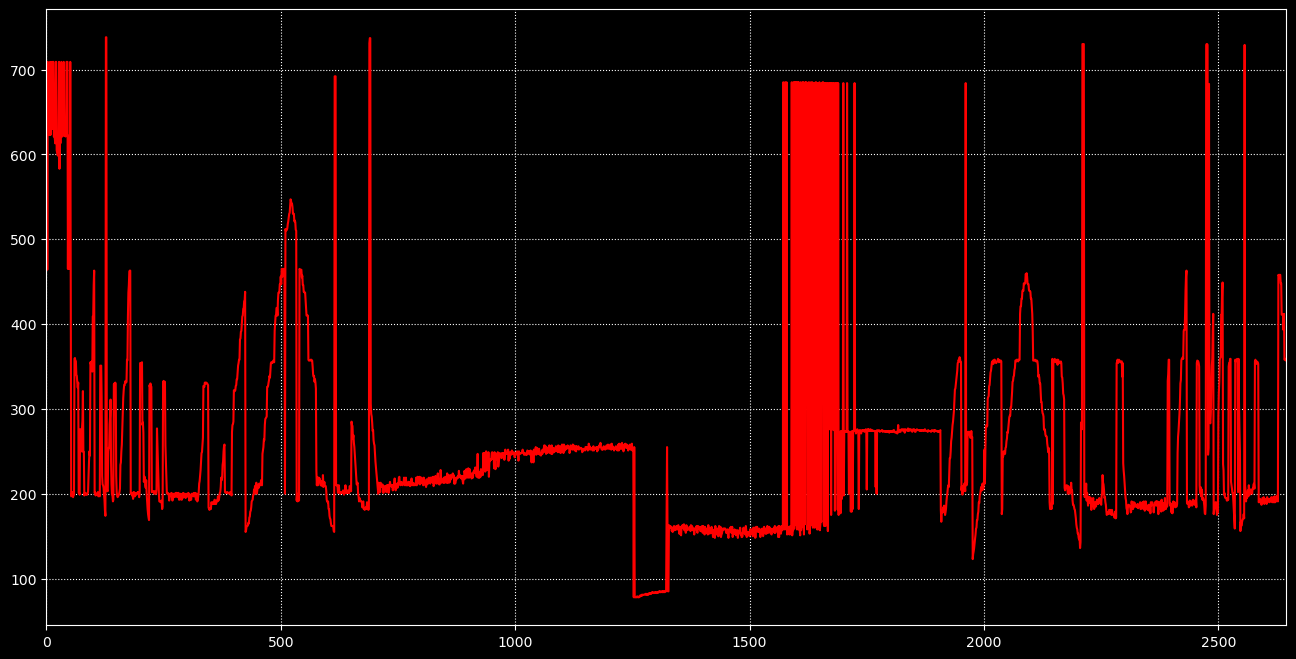

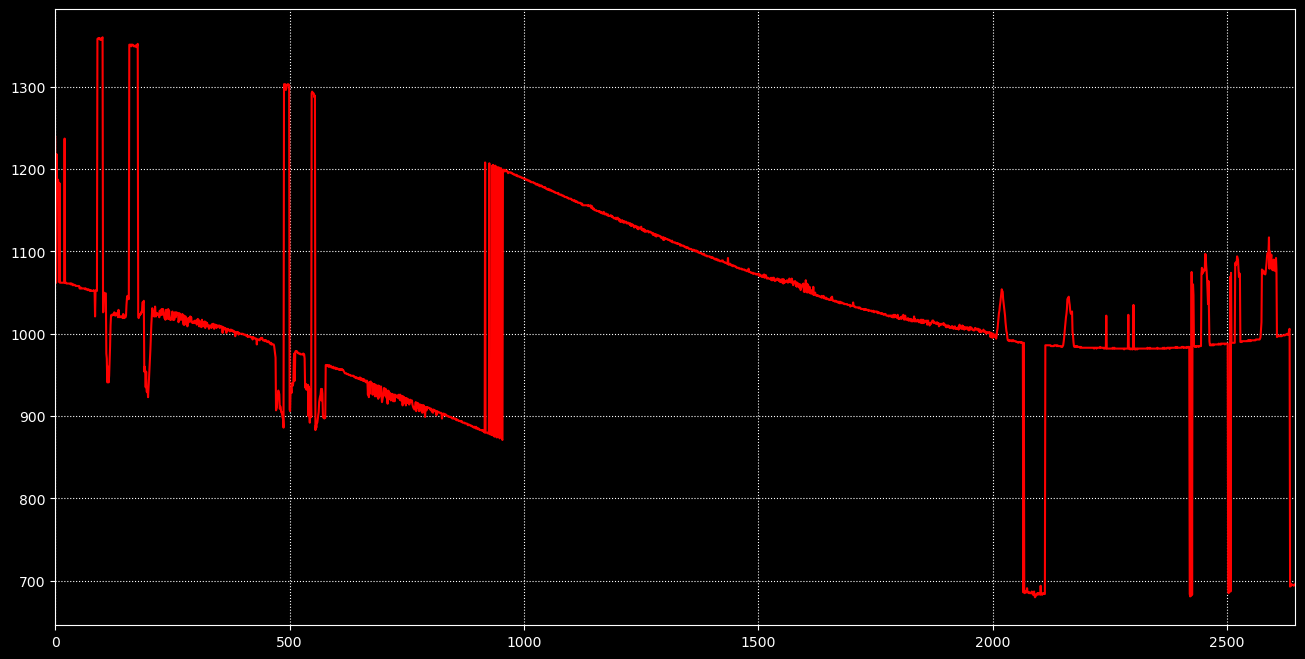

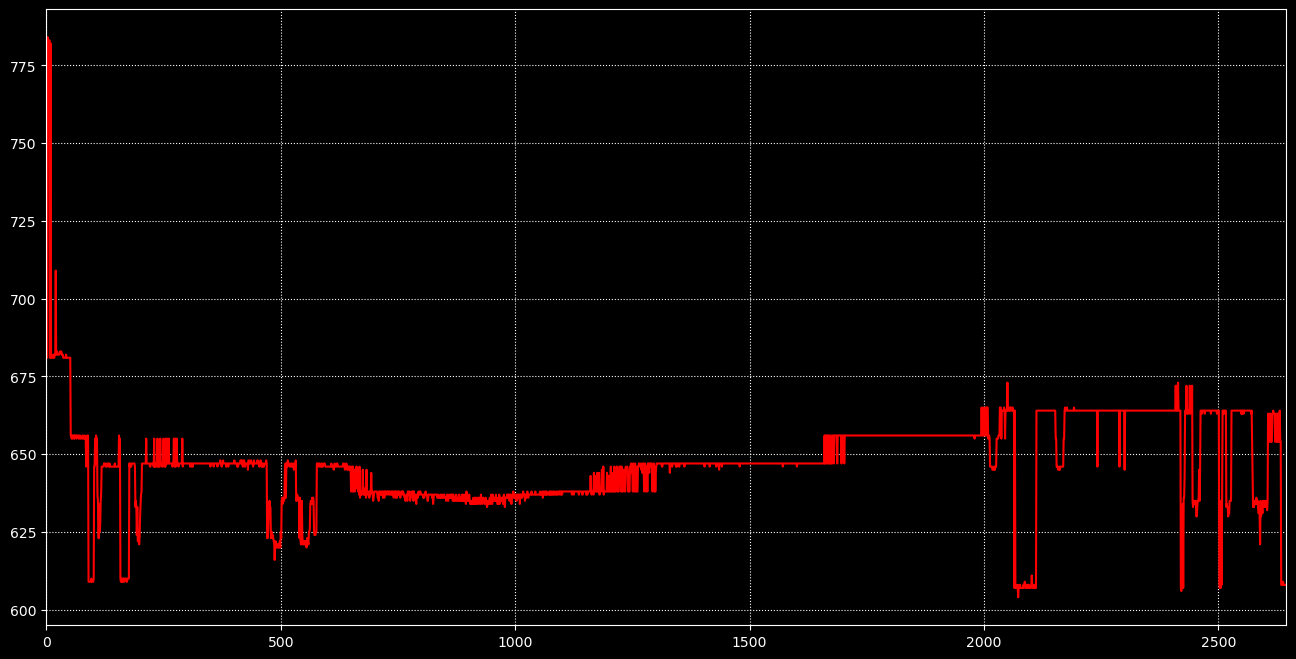

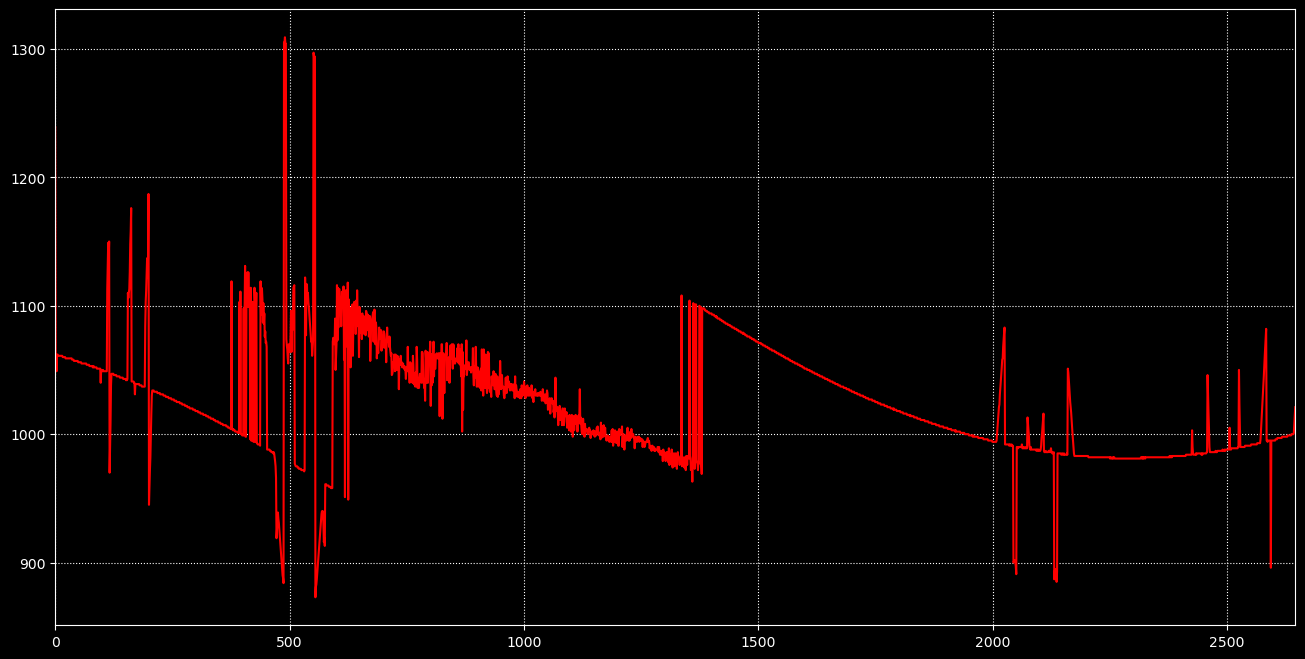

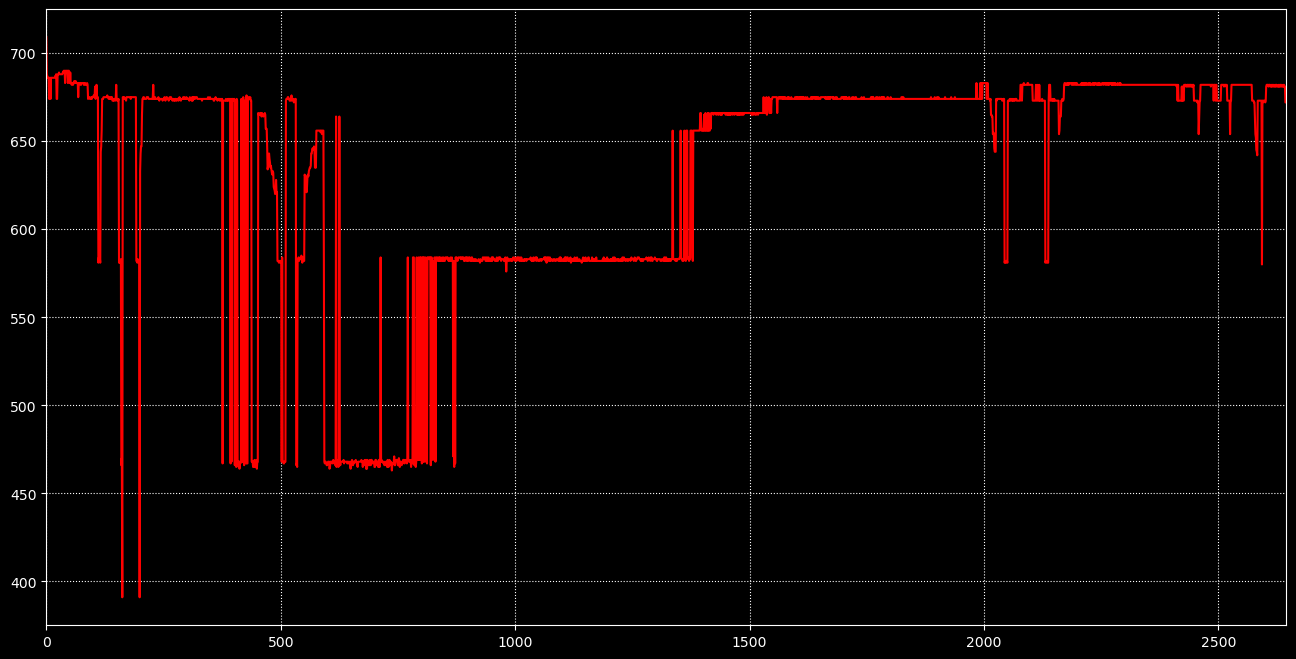

In [10]:
ress = loadData("/home/imbl/usr/src/bctppl/test/tracked_org.dat")

rests = []
for resC in range(len(ress)) :
    rests.append(torch.tensor(ress[resC], dtype=int))
rest = torch.stack(rests)
ind = rest[0,:].argsort(dim=0)
resS = rest[:,ind]

print("")
for indx in range(13) :
    plotData((resS[indx].numpy(),))
